<a href="https://colab.research.google.com/github/aydawudu/IAX/blob/main/IAX_AA_Delay_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -r req_3.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 752.5/752.5 kB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 24.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

## Loading Libraries

In [2]:
import math
import machine_learning_datasets as mldatasets
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics, linear_model, tree, naive_bayes, neighbors,\
                    ensemble, neural_network, svm

from rulefit import RuleFit
import statsmodels.api as sm

from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
from interpret.perf import ROC

import tensorflow as tf
from gaminet import GAMINet
from gaminet.utils import plot_trajectory, plot_regularization,\
                          local_visualize, global_visualize_density, \
                          feature_importance_visualize

import matplotlib.pyplot as plt
import joblib


##Understanding and Preparing the Data

In [3]:
aad18_df = mldatasets.load("aa-domestic-delays-2018")

https://github.com/PacktPublishing/Interpretable-Machine-Learning-with-Python/raw/master/datasets/aa-domestic-delays-2018.csv.zip downloaded to /content/data/aa-domestic-delays-2018.csv.zip
/content/data/aa-domestic-delays-2018.csv.zip uncompressed to /content/data/aa-domestic-delays-2018.csv
1 dataset files found in /content/data/aa-domestic-delays-2018.csv folder
parsing /content/data/aa-domestic-delays-2018.csv/aa-domestic-delays-2018.csv


In [4]:
print(aad18_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899527 entries, 0 to 899526
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   FL_NUM                899527 non-null  int64  
 1   ORIGIN                899527 non-null  object 
 2   DEST                  899527 non-null  object 
 3   PLANNED_DEP_DATETIME  899527 non-null  object 
 4   CRS_DEP_TIME          899527 non-null  int64  
 5   DEP_TIME              899527 non-null  float64
 6   DEP_DELAY             899527 non-null  float64
 7   DEP_AFPH              899527 non-null  float64
 8   DEP_RFPH              899527 non-null  float64
 9   TAXI_OUT              899527 non-null  float64
 10  WHEELS_OFF            899527 non-null  float64
 11  CRS_ELAPSED_TIME      899527 non-null  float64
 12  PCT_ELAPSED_TIME      899527 non-null  float64
 13  DISTANCE              899527 non-null  float64
 14  CRS_ARR_TIME          899527 non-null  int64  
 15  

##Data Preparation

In [5]:
# change the PLANNED_DEP_DATETIME to datetime
aad18_df['PLANNED_DEP_DATETIME']=pd.to_datetime(aad18_df['PLANNED_DEP_DATETIME'])

In [6]:
#derive day of week and month of year
aad18_df['DEP_MONTH']=aad18_df['PLANNED_DEP_DATETIME'].dt.month
aad18_df['DEP_DOW']=aad18_df['PLANNED_DEP_DATETIME'].dt.dayofweek

In [7]:
#drop the PLANNED_DEP_DATETIME since we do not need it anymore since we are /
#focusing on weekends and winters to study bad delays
aad18_df=aad18_df.drop(['PLANNED_DEP_DATETIME'], axis=1)

In [8]:
#create list of the 10 hubs
hubs=['CLT', 'ORD', 'DTW', 'LAX', 'MIA', 'JFK', 'LGA', 'PHL', 'PHX', 'DCA']

#create boolean series for if ORIGIN or DEST are hubs
is_origin_hub=aad18_df['ORIGIN'].isin(hubs)
is_dest_hub=aad18_df['DEST'].isin(hubs)

#use boolean series to set ORIGIN_HUB and DEST_HUB
aad18_df['ORIGIN_HUB']=0
aad18_df.loc[is_origin_hub, 'ORIGIN_HUB']=1
aad18_df['DEST_HUB']=0
aad18_df.loc[is_dest_hub, 'DEST_HUB']=1

#Delect columns with airport codes
aad18_df=aad18_df.drop(['FL_NUM', 'ORIGIN', 'DEST'], axis=1)

In [9]:
#figuring out the target feature betweeb ARR_DELAY and CARRIER_DELAY
aad18_df.loc[aad18_df['ARR_DELAY']>15, ['ARR_DELAY','CARRIER_DELAY']].head(10)


ARR_DELAY  CARRIER_DELAY
8       168.0          136.0
16       20.0            5.0
18      242.0          242.0
19       62.0           62.0
22       19.0           19.0
26       26.0            0.0
29       77.0           77.0
32       19.0           19.0
33       18.0            1.0
40       36.0           16.0

In [10]:
#focus on CARRIER_DELAY which is delay attributed to the airline
aad18_df=aad18_df.drop(['ARR_DELAY'], axis=1)

In [11]:
#fixing a random state
rand=9
np.random.seed(rand)

#split the dataset for both regression and classification model
y=aad18_df['CARRIER_DELAY']
X=aad18_df.drop(['CARRIER_DELAY'], axis=1).copy()
X_train, X_test, y_train_reg, y_test_reg=train_test_split(X, y, test_size=0.15, random_state=rand)
y_train_class=y_train_reg.apply(lambda x: 1 if x > 15 else 0)
y_test_class=y_test_reg.apply(lambda x: 1 if x > 15 else 0)

In [12]:
from operator import add
#lets compare how linearly correlated out features to the target CARRIER_DELAY
#using pearson's correlation coeffiecint and turn them into absolute values and sort
corr=aad18_df.corr()
abs(corr['CARRIER_DELAY']).sort_values(ascending=False)

CARRIER_DELAY          1.000000
DEP_DELAY              0.703935
ARR_RFPH               0.101742
LATE_AIRCRAFT_DELAY    0.083166
DEP_RFPH               0.058659
ARR_AFPH               0.035135
DEP_TIME               0.030941
NAS_DELAY              0.026792
WHEELS_OFF             0.026787
TAXI_OUT               0.024635
PCT_ELAPSED_TIME       0.020980
CRS_DEP_TIME           0.016032
DEST_HUB               0.013732
DISTANCE               0.010680
DEP_MONTH              0.009728
CRS_ELAPSED_TIME       0.008801
DEP_DOW                0.007043
CRS_ARR_TIME           0.007029
DEP_AFPH               0.006053
WEATHER_DELAY          0.003002
ORIGIN_HUB             0.001148
SECURITY_DELAY         0.000460
Name: CARRIER_DELAY, dtype: float64

only DEP_DELAY is linearly correlated. Let's explore non-linear correlation

##Reviewing Traditional Model Interpretation Methods

### Predicting Minutes Delayed with Various Regression Methods


In [13]:
# #dictionary of multiple regression model
reg_models = {
        #Generalized Linear Models (GLMs)
        'linear':{'model': linear_model.LinearRegression()},
        'linear_poly':{'model': make_pipeline(PolynomialFeatures(degree=2),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'linear_interact':{'model': make_pipeline(PolynomialFeatures(interaction_only=True),
                              linear_model.LinearRegression(fit_intercept=False)) },
        'ridge':{'model': linear_model.RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1]) },
        #Trees
        'decision_tree':{'model': tree.DecisionTreeRegressor(max_depth=7, random_state=rand)},
        #RuleFit
        'rulefit':{'model': RuleFit(max_rules=150, rfmode='regress', random_state=rand)},
        #Nearest Neighbors
        'knn':{'model': neighbors.KNeighborsRegressor(n_neighbors=7)},
        #Ensemble Methods
        'random_forest':{'model':ensemble.RandomForestRegressor(max_depth=7, random_state=rand)},
        #Neural Networks
        'mlp':{'model':neural_network.MLPRegressor(hidden_layer_sizes=(21,), max_iter=500,
                                                   early_stopping=True, random_state=rand)}
    }

In [14]:
%%time
# for model_name in reg_models.keys():
#     print(model_name)
#     if model_name != 'rulefit':
#         fitted_model = reg_models[model_name]['model'].fit(X_train, y_train_reg)
#         y_train_pred = fitted_model.predict(X_train)
#         y_test_pred = fitted_model.predict(X_test)
#     else:
#         fitted_model = reg_models[model_name]['model'].fit(X_train.values, y_train_reg.values, X_test.columns)
#         y_train_pred = fitted_model.predict(X_train.values)
#         y_test_pred = fitted_model.predict(X_test.values)
#     reg_models[model_name]['fitted'] = fitted_model
#     reg_models[model_name]['preds'] = y_test_pred
#     reg_models[model_name]['RMSE_train'] = math.sqrt(metrics.mean_squared_error(y_train_reg, y_train_pred))
#     reg_models[model_name]['RMSE_test'] = math.sqrt(metrics.mean_squared_error(y_test_reg, y_test_pred))
#     reg_models[model_name]['R2_test'] = metrics.r2_score(y_test_reg, y_test_pred)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs


In [15]:
# ##save the models
# import joblib
# filename='reg_models.sav'
# joblib.dump(reg_models, filename)


In [16]:
#load the model
filename='reg_models.sav'
reg_models= joblib.load(filename)

In [17]:
# #convert to dictionary
reg_metrics=pd.DataFrame.from_dict(reg_models, 'index')[['RMSE_train', 'RMSE_test', 'R2_test']]
reg_metrics.sort_values(by='RMSE_test').style.format({'RMSE_train':\
                                                     '{:.2f}', 'RMSE_test': '{:.2f}', 'R2_test':'{:.3f}'}).\
                background_gradient(cmap='viridis_r', low=0.1, high=1, subset=['RMSE_train', 'RMSE_test']).\
                background_gradient(cmap='plasma', low=0.1, high=1, subset=['R2_test'])

##Classifying Flights as Delayed or Not Delayed with Various Classification Methods


### Training and Evaluating the Classification Models

In [18]:
class_models={
    #Generalized Linear Models (GLMs)
    'logistic':{'model':linear_model.LogisticRegression()},
    'ridge': {'model': linear_model.RidgeClassifierCV(cv=5, alphas=[1e-3, 1e-2, 1e-1, 1],\
                                                     class_weight='balanced')},
    #Tree
    'decision_tree': {'model': tree.DecisionTreeClassifier(max_depth=7, random_state=rand)},
    #Nearest Neigbors
    'knn':{'model':neighbors.KNeighborsClassifier(n_neighbors=7)},
    #Naive Bayes
    'naive_bayes':{'model':naive_bayes.GaussianNB()},
    #Ensemble Methods
    'gradient_boosting': {'model':ensemble.GradientBoostingClassifier(n_estimators=210)},
    'random_forest':{'model': ensemble.RandomForestClassifier(max_depth=11, \
                                                              class_weight='balanced', random_state=rand)},
    #Neural Networks
    'mlp':{'model':make_pipeline(StandardScaler(), \
                                 neural_network.MLPClassifier(hidden_layer_sizes=(7, ), max_iter=500,
                                                                             early_stopping=True, random_state=rand))}
    }

In [19]:
#how balanced is our data
print(y_train_class[y_train_class==1].shape[0]/y_train_class.shape[0])

0.061283264255549


In [20]:
#fit our model
# %%time
# for model_name in class_models.keys():
#   print(model_name)
#   fitted_model=class_models[model_name]['model'].fit(X_train, y_train_class)
#   y_train_pred=fitted_model.predict(X_train)
#   if model_name =='ridge':
#     y_test_pred=fitted_model.predict(X_test)
#   else:
#     y_test_prob=fitted_model.predict_proba(X_test)[:, 1]
#     y_test_pred=np.where(y_test_prob >0.5, 1, 0)

#   class_models[model_name]['fitted']=fitted_model
#   class_models[model_name]['probs']=y_test_prob
#   class_models[model_name]['preds']=y_test_pred
#   class_models[model_name]['Accuracy_train']=metrics.accuracy_score(y_train_class, y_train_pred)
#   class_models[model_name]['Accuracy_test']=metrics.accuracy_score(y_test_class, y_test_pred)
#   class_models[model_name]['Recall_train']=metrics.recall_score(y_train_class, y_train_pred)
#   class_models[model_name]['Recall_test']=metrics.recall_score(y_test_class, y_test_pred)
#   if model_name != 'ridge':
#     class_models[model_name]['ROC_AUC_test']=metrics.roc_auc_score(y_test_class, y_test_prob)
#   else:
#     class_models[model_name]['ROC_AUC_test']=np.nan
#   class_models[model_name]['F1_test']=metrics.f1_score(y_test_class, y_test_pred)
#   class_models[model_name]['MCC_test'] = metrics.matthews_corrcoef(y_test_class, y_test_pred)

In [21]:
# #Save class model
# filename1='class_models.sav'
# joblib.dump(class_models, filename1)

In [22]:
#load class the model
filename1='class_models.sav'
class_models= joblib.load(filename1)

In [23]:
#convert dictionary to dataframe
class_metrics = pd.DataFrame.from_dict(class_models, 'index')[['Accuracy_train', 'Accuracy_test',\
                                                               'Recall_train', 'Recall_test',\
                                                               'ROC_AUC_test', 'F1_test', 'MCC_test']]
class_metrics.sort_values(by='ROC_AUC_test', ascending=False).style.\
    format(dict(zip(class_metrics.columns, ['{:.3f}']*7))).\
    background_gradient(cmap='plasma', low=1, high=0.1, subset=['Accuracy_train', 'Accuracy_test']).\
    background_gradient(cmap='viridis', low=1, high=0.1, subset=['Recall_train', 'Recall_test',\
                                                                 'ROC_AUC_test', 'F1_test', 'MCC_test'])

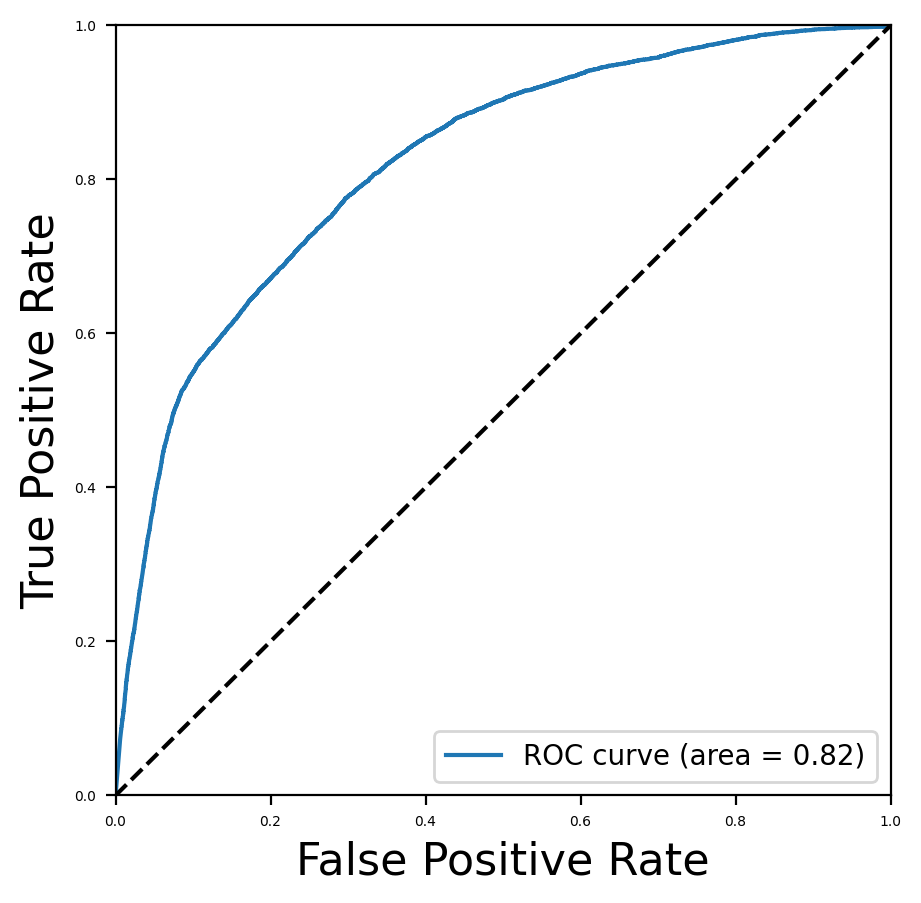

In [24]:
#ROC curve for the worst_performing model
plt.figure(figsize=(5,5), dpi=200)
plt.tick_params(axis='both', which='major', labelsize=5)
fpr, tpr, _ =metrics.roc_curve(y_test_class, class_models['naive_bayes']['probs'])
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % class_models['naive_bayes']['ROC_AUC_test'])
plt.plot([0, 1], [0, 1], 'k--') #coin toss line
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")
plt.show()

# Studying Intrinsically interpretable (White-box) models
## Generalized Linear Models (GLMs)

### Linear Regression

- To rely on Linear Regression model, the model has to meet the assumption of linearity, normality, lack of multicollinearity and homoscedascity.

- To inteprete Linear Regression, just use the coefficients


In [25]:
#To interpret
coefs_lm = reg_models['linear']['fitted'].coef_
intercept_lm = reg_models['linear']['fitted'].intercept_
print('coefficients:\t%s' % coefs_lm)
print('intercept:\t%s' % intercept_lm)

coefficients:	[ 4.51091892e-03 -5.28082234e-03  8.93885687e-01 -1.94169926e-02
 -4.74610238e-01  1.22151837e-01 -5.87132043e-04 -1.51131357e-02
  4.52489037e+01  9.19092839e-04 -3.46494440e-04  1.44923469e-03
  3.71785586e-01 -9.06828774e-01 -6.74030929e-01 -9.18186819e-01
 -9.29430939e-01 -4.07957099e-02 -1.97393342e-02 -2.15761239e-01
  1.88947348e-01]
intercept:	-38.54584957005184


In [26]:
print('ŷ = %0.2f + %0.4fX₁ + %0.4fX₂ + %0.3fX₃ + ...' %\
      (intercept_lm, coefs_lm[0], coefs_lm[1], coefs_lm[2]))

ŷ = -38.55 + 0.0045X₁ + -0.0053X₂ + 0.894X₃ + ...


In [27]:
#Let's put the coefficient in a dataframe to make the interpretation more management
pd.DataFrame ({'features':X_train.columns.tolist(),\
               'coef':coefs_lm.tolist()})

features       coef
0          CRS_DEP_TIME   0.004511
1              DEP_TIME  -0.005281
2             DEP_DELAY   0.893886
3              DEP_AFPH  -0.019417
4              DEP_RFPH  -0.474610
5              TAXI_OUT   0.122152
6            WHEELS_OFF  -0.000587
7      CRS_ELAPSED_TIME  -0.015113
8      PCT_ELAPSED_TIME  45.248904
9              DISTANCE   0.000919
10         CRS_ARR_TIME  -0.000346
11             ARR_AFPH   0.001449
12             ARR_RFPH   0.371786
13        WEATHER_DELAY  -0.906829
14            NAS_DELAY  -0.674031
15       SECURITY_DELAY  -0.918187
16  LATE_AIRCRAFT_DELAY  -0.929431
17            DEP_MONTH  -0.040796
18              DEP_DOW  -0.019739
19           ORIGIN_HUB  -0.215761
20             DEST_HUB   0.188947

In [28]:
#Using T_stats to measure feature importance
linreg_mdl=sm.OLS(y_train_reg, sm.add_constant(X_train))
linreg_mdl=linreg_mdl.fit()
print(linreg_mdl.summary())

                            OLS Regression Results                            
Dep. Variable:          CARRIER_DELAY   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.921
Method:                 Least Squares   F-statistic:                 4.244e+05
Date:                Thu, 18 Jan 2024   Prob (F-statistic):               0.00
Time:                        11:31:58   Log-Likelihood:            -2.6580e+06
No. Observations:              764597   AIC:                         5.316e+06
Df Residuals:                  764575   BIC:                         5.316e+06
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -38.5458    

In [29]:
#turn the statsummary into DataFrame
summary_df=linreg_mdl.summary2().tables[1]
summary_df=summary_df.drop(['const']).reset_index().rename(columns={'index':'feature'})
summary_df['t_abs']=abs(summary_df['t'])
summary_df.sort_values(by='t_abs', ascending=False).style.\
  format(dict(zip(summary_df.columns[1:], ['{:.4f}']*7))).\
  background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['P>|t|', 't_abs'])

### Ridge Regression

Also known as penalized regression. It uses L2 norm

In [30]:
#comparing linear model coefficient with rigde model coefficinet
coefs_ridge=reg_models['ridge']['fitted'].coef_
coefs_ridge_df=pd.DataFrame({'feature': X_train.columns.values.tolist(), \
                             'coef_linear':coefs_lm, \
                             'coef_ridge': coefs_ridge})
coefs_ridge_df['coef_regularization']=coefs_ridge_df['coef_linear'] - coefs_ridge_df['coef_ridge']
coefs_ridge_df.style.background_gradient(cmap='plasma_r', low=0, high=0.1, subset=['coef_regularization'])


The coefficient are slightly difference. Let's run a experiment to figure out the optimal alphas values

In [31]:
num_alphas=100
alphas=np.logspace(0, 13, num_alphas)
alphas_coefs=[]
for alpha in alphas:
  ridge=linear_model.Ridge(alpha=alpha).fit(X_train, y_train_reg)
  alphas_coefs.append(np.concatenate((ridge.coef_[:8], ridge.coef_[9:])))

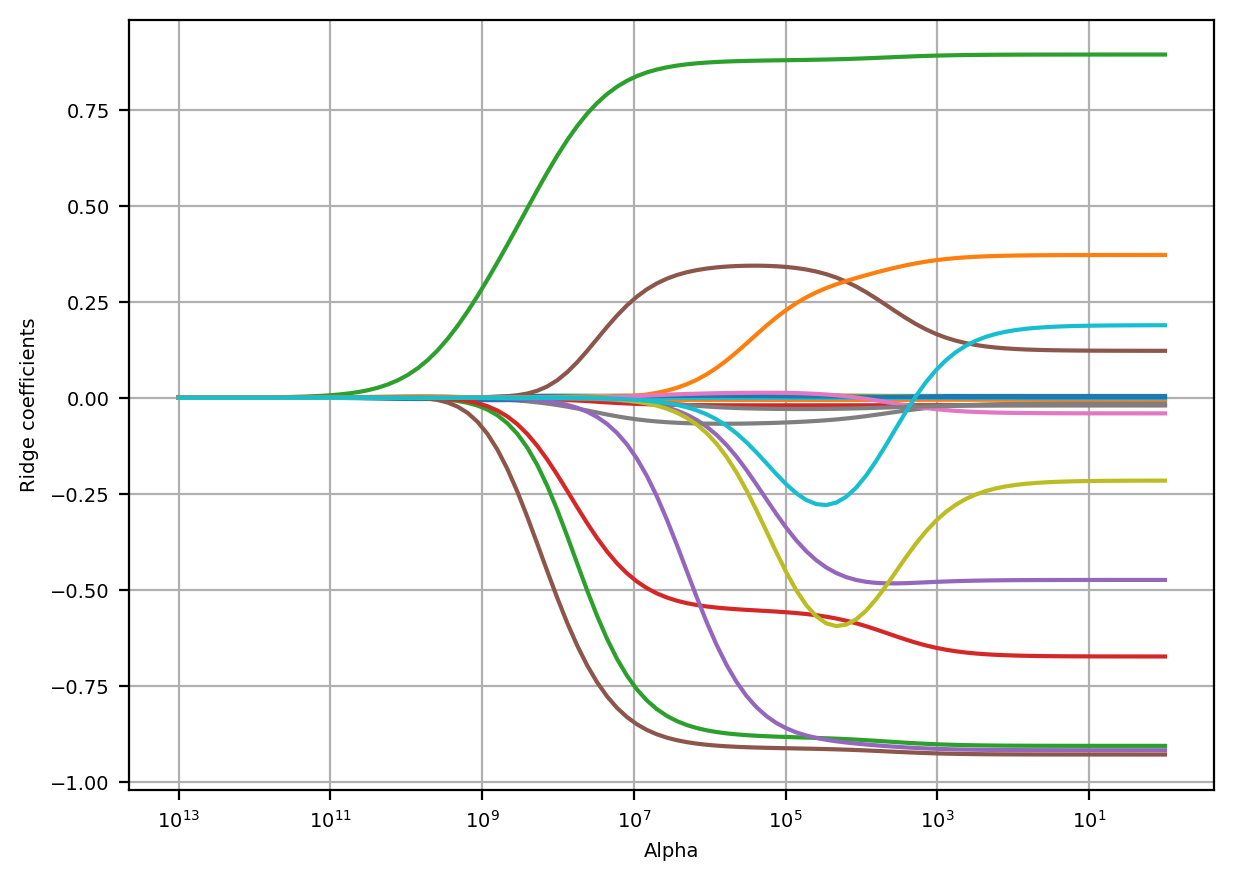

In [32]:
plt.figure(figsize=(7, 5), dpi=200)
plt.gca().invert_xaxis()
plt.tick_params(axis='both', which ='major', labelsize = 7)
plt.plot(alphas, alphas_coefs)
plt.xscale("log")
plt.xlabel('Alpha', fontsize =7)
plt.ylabel('Ridge coefficients', fontsize = 7)
plt.grid()
plt.show()

### Polynomial Regression

Features are expanded to have a higer degree terms


In [33]:
print(reg_models['linear_poly']['fitted'].get_params()['linearregression'].coef_.shape[0])

253


In [34]:
print(reg_models['linear_interact']['fitted'].get_params()['linearregression'].coef_.shape[0])

232


### Logistic Regression

In [35]:
coefs_log=class_models['logistic']['fitted'].coef_
intercept_log=class_models['logistic']['fitted'].intercept_
print('coefficients:\t%s' % coefs_log)
print('intercept : \t%s' % intercept_log)

coefficients:	[[-1.34427769e-03 -1.82153804e-04  1.64345526e-01  2.12102309e-03
  -2.34659326e-03 -1.41029053e-03  8.40449851e-04 -5.57777193e-02
  -1.87209139e-03  6.11058127e-03 -1.91210657e-04 -1.21418339e-02
  -2.90999788e-03 -1.70555590e-01 -1.35639168e-01 -6.82310915e-03
  -1.65538563e-01 -1.42236853e-02 -5.79853715e-03  2.69559484e-05
  -1.92170574e-03]]
intercept : 	[-0.00251428]


interpretation: With each unit increase in the features, you increase the odds of getting the positive case by a factor all things being equal

In [36]:
#crude method of deriving feature importance
stdv = np.std(X_train, 0)
abs(coefs_log.reshape(21, )* stdv).sort_values(ascending=False)

DEP_DELAY              7.274657
CRS_ELAPSED_TIME       4.427401
LATE_AIRCRAFT_DELAY    4.090734
DISTANCE               3.968377
NAS_DELAY              1.869114
WEATHER_DELAY          1.782262
CRS_DEP_TIME           0.674030
WHEELS_OFF             0.434172
ARR_AFPH               0.429374
CRS_ARR_TIME           0.100985
DEP_TIME               0.093792
DEP_AFPH               0.075201
DEP_MONTH              0.048541
TAXI_OUT               0.013918
DEP_DOW                0.011588
SECURITY_DELAY         0.011184
ARR_RFPH               0.002099
DEP_RFPH               0.001326
DEST_HUB               0.000959
PCT_ELAPSED_TIME       0.000197
ORIGIN_HUB             0.000013
dtype: float64

### Decision Trees

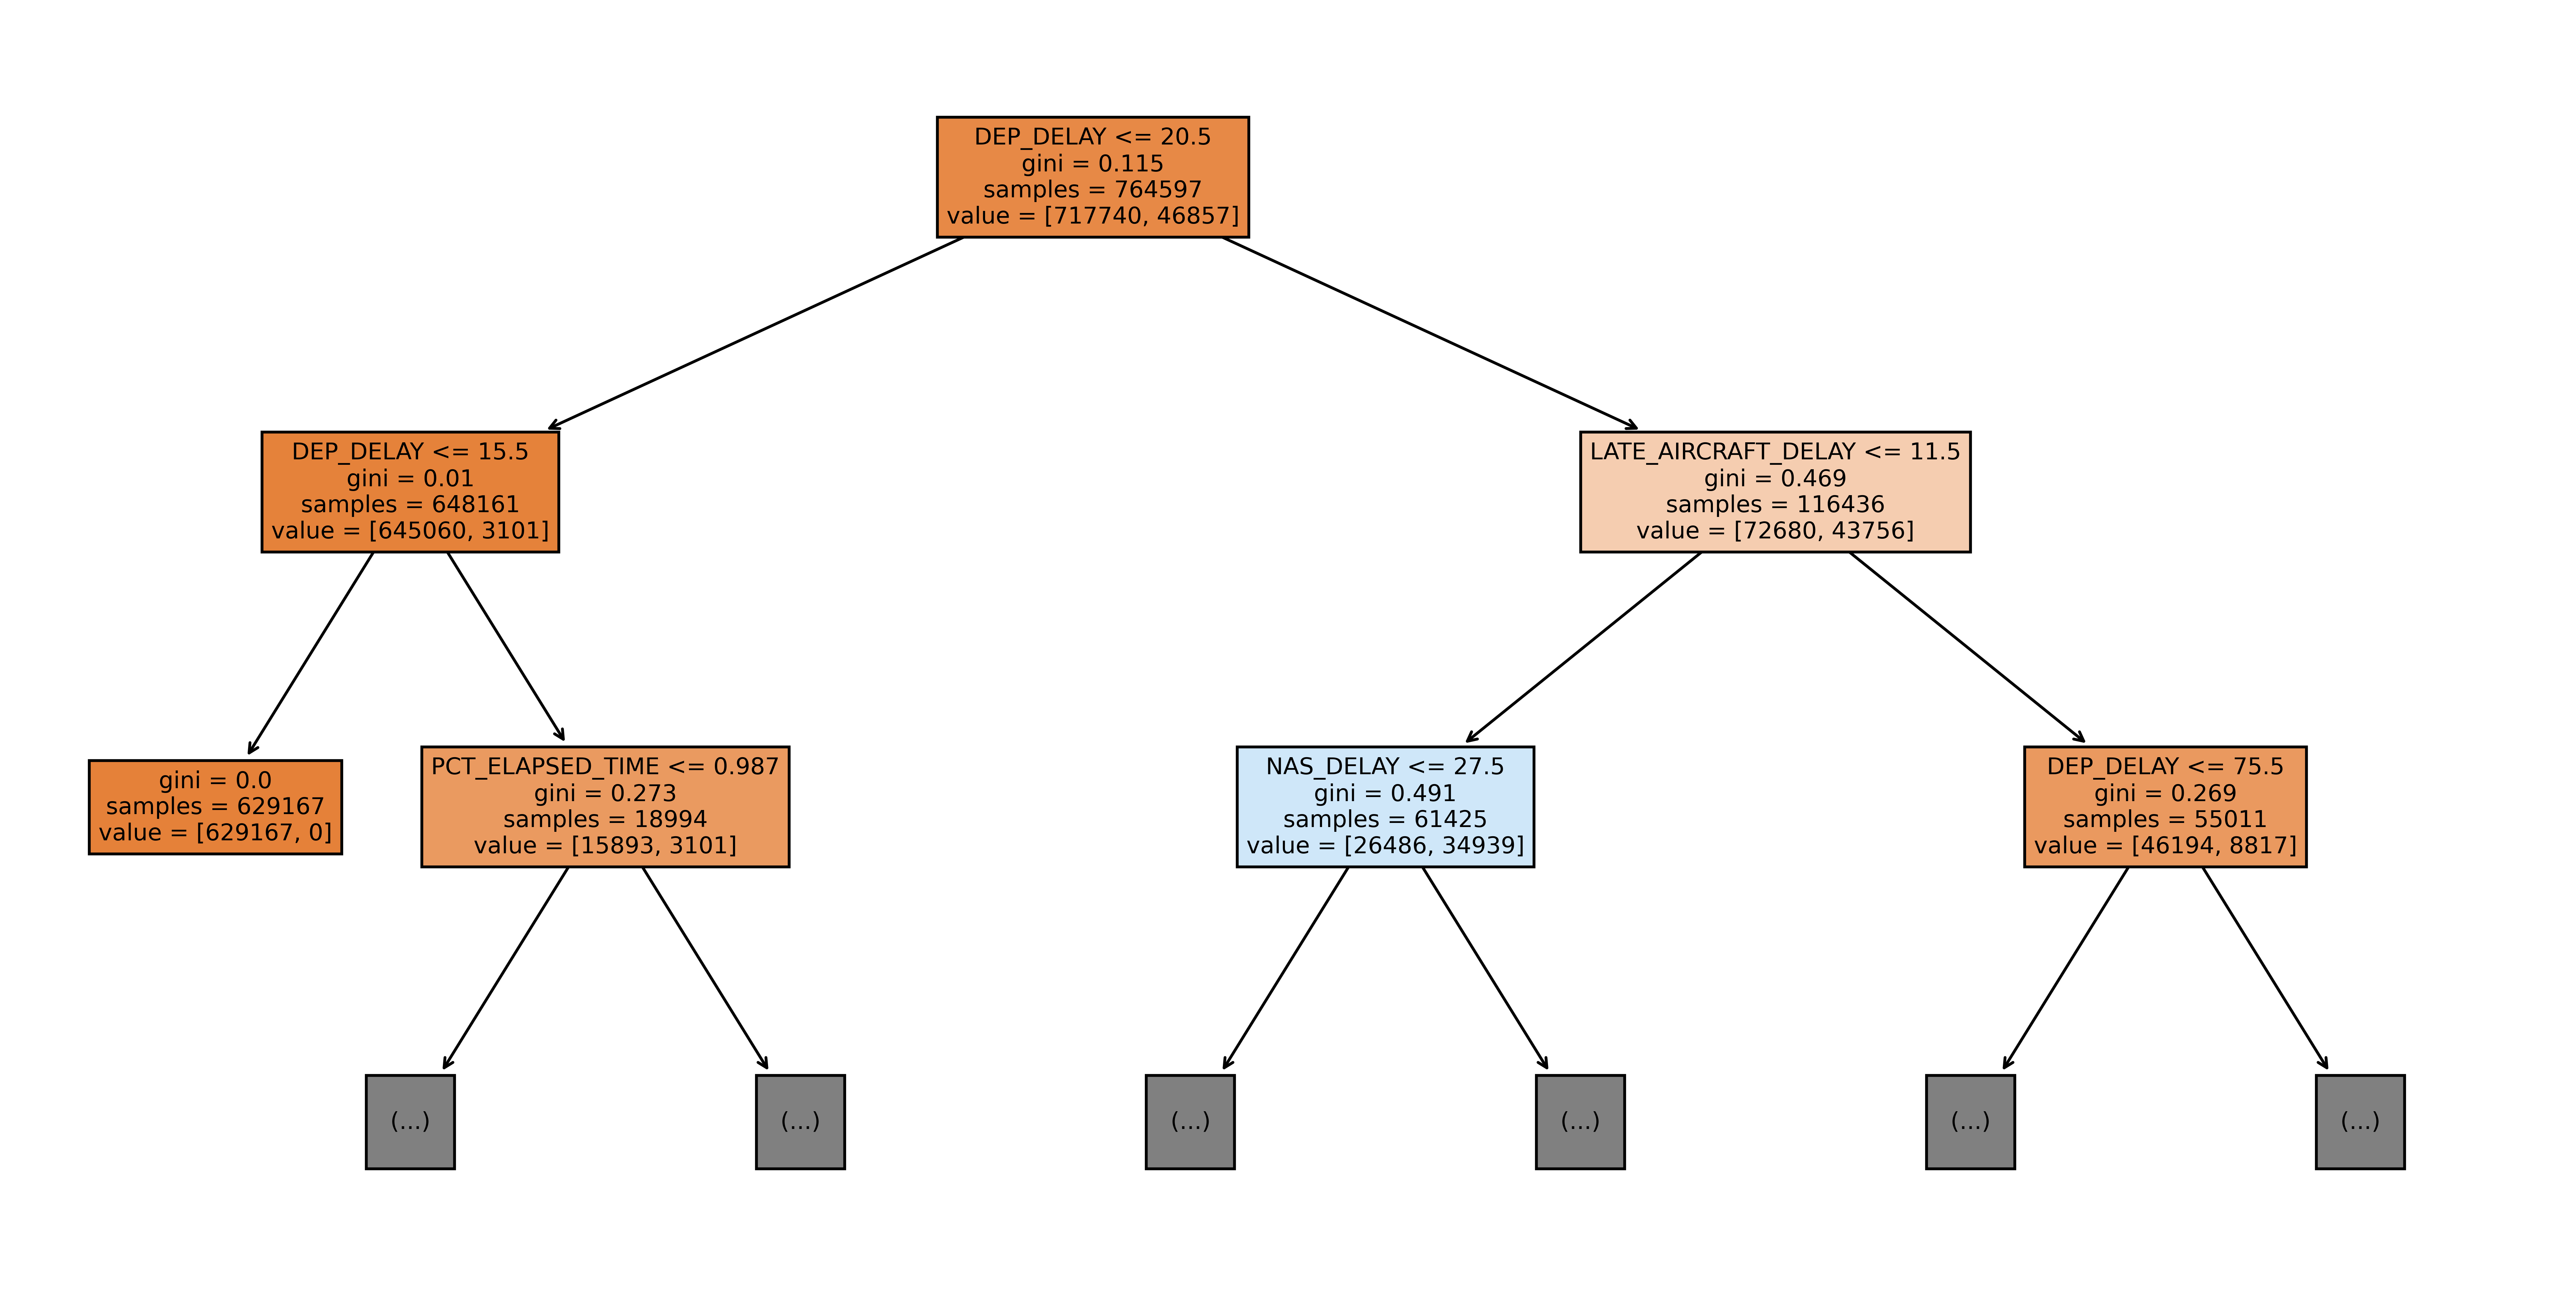

In [37]:
#CART Decision Trees
fig, axes =plt.subplots(nrows =1, ncols=1, figsize=(16, 8) , dpi = 600)
tree.plot_tree(class_models['decision_tree']['fitted'], \
               feature_names=X_train.columns.values.tolist(), filled = True, max_depth=2)
fig.show()

In [38]:
#printing the decision tree by branches
text_tree=tree.export_text(class_models['decision_tree']['fitted'], \
                      feature_names=X_train.columns.values.tolist())
print(text_tree)

|--- DEP_DELAY <= 20.50
|   |--- DEP_DELAY <= 15.50
|   |   |--- class: 0
|   |--- DEP_DELAY >  15.50
|   |   |--- PCT_ELAPSED_TIME <= 0.99
|   |   |   |--- PCT_ELAPSED_TIME <= 0.98
|   |   |   |   |--- PCT_ELAPSED_TIME <= 0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.94
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- CRS_ELAPSED_TIME >  65.50
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME <= 0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- PCT_ELAPSED_TIME >  0.95
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |--- PCT_ELAPSED_TIME >  0.96
|   |   |   |   |   |--- CRS_ELAPSED_TIME <= 140.50
|   |   |   |   |   |   |--- DEP_DELAY <= 18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- DEP_DELAY >  18.50
|   |   |   |   |   |   |   |--- class: 0
|   |   

In [39]:
#Calculating the Feature Importance
dt_imp_df=pd.DataFrame({'feature': X_train.columns.values.tolist(),
                        'importance': class_models['decision_tree']['fitted'].feature_importances_}).\
                        sort_values(by='importance', ascending=False)
dt_imp_df

feature  importance
2             DEP_DELAY    0.527482
16  LATE_AIRCRAFT_DELAY    0.199153
8      PCT_ELAPSED_TIME    0.105381
13        WEATHER_DELAY    0.101649
14            NAS_DELAY    0.062732
15       SECURITY_DELAY    0.001998
9              DISTANCE    0.001019
7      CRS_ELAPSED_TIME    0.000281
5              TAXI_OUT    0.000239
6            WHEELS_OFF    0.000035
3              DEP_AFPH    0.000031
0          CRS_DEP_TIME    0.000000
19           ORIGIN_HUB    0.000000
18              DEP_DOW    0.000000
17            DEP_MONTH    0.000000
10         CRS_ARR_TIME    0.000000
12             ARR_RFPH    0.000000
11             ARR_AFPH    0.000000
1              DEP_TIME    0.000000
4              DEP_RFPH    0.000000
20             DEST_HUB    0.000000

In [40]:
#RuleFit
rulefit_df=reg_models['rulefit']['fitted'].get_rules()
rulefit_df= rulefit_df[rulefit_df.coef !=0].sort_values(by="importance", ascending=False)
rulefit_df

rule    type        coef  \
39   WEATHER_DELAY <= 166.0 & LATE_AIRCRAFT_DELAY <...    rule  216.760856   
88    DEP_DELAY > 477.5 & LATE_AIRCRAFT_DELAY <= 333.5    rule  176.310048   
16                                 LATE_AIRCRAFT_DELAY  linear   -0.390238   
2                                            DEP_DELAY  linear    0.164051   
48                                  DEP_DELAY > 1206.0    rule  245.239224   
..                                                 ...     ...         ...   
63   DEP_DELAY <= 68.5 & DEP_DELAY <= 20.5 & DEP_DE...    rule   -0.050093   
18                                             DEP_DOW  linear    0.008883   
19                                          ORIGIN_HUB  linear    0.013017   
162                                  DEP_DELAY > 880.5    rule    0.175031   
41             DEP_DELAY <= 477.5 & DEP_DELAY <= 218.5    rule   -0.014223   

      support  importance  
39   0.001684    8.886316  
88   0.001122    5.903293  
16   1.000000    4.572468  
2    1.000000    4.292009  
48   0.000187    3.353782  
..        ...         ...  
63   0.846053    0.018078  
18   1.000000    0.017752  
19   1.000000    0.006494  
162  0.000748    0.004786  
41   0.992518    0.001226  

[86 rows x 5 columns]

### Nearest Neighbors

###k-Nearest Neighbors (kNN)
There is no fitted model

In [41]:
print(X_test.loc[721043, :])

CRS_DEP_TIME            655.000000
DEP_TIME               1055.000000
DEP_DELAY               240.000000
DEP_AFPH                 90.800000
DEP_RFPH                  0.890196
TAXI_OUT                 35.000000
WHEELS_OFF             1130.000000
CRS_ELAPSED_TIME        259.000000
PCT_ELAPSED_TIME          1.084942
DISTANCE               1660.000000
CRS_ARR_TIME            914.000000
ARR_AFPH                 40.434783
ARR_RFPH                  1.064073
WEATHER_DELAY             0.000000
NAS_DELAY                22.000000
SECURITY_DELAY            0.000000
LATE_AIRCRAFT_DELAY     221.000000
DEP_MONTH                10.000000
DEP_DOW                   4.000000
ORIGIN_HUB                0.000000
DEST_HUB                  0.000000
Name: 721043, dtype: float64


In [42]:
#actual target
print(y_test_class[721043])

1


In [43]:
#predicted target
print(class_models['knn']['preds'][X_test.index.get_loc(721043)])

0


In [44]:
#derive 7 nearest neighbors to the point
print(class_models['knn']['fitted'].kneighbors(X_test.loc[721043, :].values.reshape(1, 21), 7))

(array([[143.3160128 , 173.91027582, 192.66965241, 211.57345547,
        243.5741713 , 259.614014  , 259.77314916]]), array([[105172, 571912,  73409,  89450,  77474, 705972, 706911]]))


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [45]:
print(y_train_class.iloc[[105172, 571912,  73409,  89450,  77474, 705972, 706911]])

3813      0
229062    1
283316    0
385831    0
581905    1
726784    1
179364    0
Name: CARRIER_DELAY, dtype: int64


In [46]:
print(class_models['knn']['fitted'].effective_metric_)

euclidean


### Naïve Bayes
### Gaussian Naïve Bayes

In [47]:
print(class_models['naive_bayes']['fitted'].class_prior_)

[0.93871674 0.06128326]


In [48]:
print(class_models['naive_bayes']['fitted'].var_)

[[2.50123026e+05 2.61324730e+05 9.21572605e+02 1.26123968e+03
  2.08339528e-01 9.58074414e+01 2.62606651e+05 6.30102550e+03
  1.13475535e-02 4.22470414e+05 2.75433641e+05 1.25314386e+03
  3.48655340e-01 1.11234714e+02 1.91877186e+02 2.80302201e+00
  5.06561612e+02 1.17346654e+01 3.99122491e+00 2.49084365e-01
  2.49619212e-01]
 [2.60629652e+05 2.96009867e+05 1.19307931e+04 1.14839167e+03
  1.99929921e+00 1.20404927e+02 3.08568277e+05 6.29066219e+03
  1.38936741e-02 4.10198938e+05 3.28574000e+05 1.09023147e+03
  3.08997044e+00 7.79140423e+01 1.56184090e+02 9.12112286e-01
  2.11279954e+03 1.02712368e+01 4.02943162e+00 2.50220036e-01
  2.36450502e-01]]


In [49]:
print(class_models['naive_bayes']['fitted'].theta_)

[[1.30740577e+03 1.31006271e+03 5.14196506e+00 5.45864877e+01
  1.09377996e+00 1.87120810e+01 1.33552258e+03 1.70734929e+02
  9.71131781e-01 1.01824369e+03 1.48438931e+03 5.39873058e+01
  1.09644787e+00 7.39971299e-01 2.85434558e+00 2.41814585e-02
  4.14674395e+00 6.55045281e+00 2.95035528e+00 4.63429654e-01
  4.71670800e-01]
 [1.41305545e+03 1.48087887e+03 8.45867640e+01 6.14731036e+01
  1.25429654e+00 1.99378321e+01 1.49409412e+03 1.72229998e+02
  9.83974416e-01 1.04363666e+03 1.54821862e+03 4.26486417e+01
  1.36373798e+00 4.50733082e-01 4.71991378e+00 2.11281132e-02
  1.40744819e+01 6.73367907e+00 3.04251232e+00 5.14202787e-01
  3.81799945e-01]]


##Discovering Newer Interpretable (Glass-box) Models

### Explainable Boosting Machine (EBM)

In [51]:
#Make new abbreviated versions of datasets
feature_samp=['DEP_DELAY','LATE_AIRCRAFT_DELAY', 'PCT_ELAPSED_TIME', 'WEATHER_DELAY', \
                            'NAS_DELAY', 'SECURITY_DELAY', 'DISTANCE', 'CRS_ELAPSED_TIME']
X_train_abbrev=X_train[feature_samp]
X_test_abbrev=X_test[feature_samp]

#for sampling among observations
sample_size= 0.1
sample_idx=np.random.choice(X_train.shape[0], math.ceil(X_train.shape[0]*sample_size), replace=False)

In [52]:
ebm_mdl=ExplainableBoostingClassifier()
ebm_mdl.fit(X_train_abbrev.iloc[sample_idx], y_train_class.iloc[sample_idx])

ExplainableBoostingClassifier()

In [53]:
# Global Interpretation
show(ebm_mdl.explain_global())

In [56]:
#Local Intepretation
ebm_lcl=ebm_mdl.explain_local(X_test_abbrev.iloc[76:77], y_test_class[76:77], name='EBM')

show(ebm_lcl)

In [57]:
#Performance
ebm_perf=ROC(ebm_mdl.predict_proba).explain_perf(X_test_abbrev, y_test_class, name='EBM')
show(ebm_perf)

## GAMI-Net

In [58]:
meta_info= {col : {"type":"continuous"} for col in X_train_abbrev.columns}

X_train_abbrev2=X_train_abbrev.copy()
X_test_abbrev2=X_test_abbrev.copy()

for key in meta_info.keys():
  scaler=MinMaxScaler()
  X_train_abbrev2[[key]] =scaler.fit_transform(X_train_abbrev2[[key]])
  X_test_abbrev2[[key]]=scaler.transform(X_test_abbrev2[[key]])
  meta_info[key]["scaler"]=scaler
meta_info["CARRIER_DELAY"]={"type":"target", "values": ["no", "yes"]}

X_train_abbrev2=X_train_abbrev2.to_numpy().astype(np.float32)
X_test_abbrev2=X_test_abbrev2.to_numpy().astype(np.float32)
y_train_class2=y_train_class.to_numpy().reshape(-1, 1)
y_test_class2=y_test_class.to_numpy().reshape(-1, 1)

In [59]:
print(meta_info)

{'DEP_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'LATE_AIRCRAFT_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'PCT_ELAPSED_TIME': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'WEATHER_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'NAS_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'SECURITY_DELAY': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'DISTANCE': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'CRS_ELAPSED_TIME': {'type': 'continuous', 'scaler': MinMaxScaler()}, 'CARRIER_DELAY': {'type': 'target', 'values': ['no', 'yes']}}


In [60]:
gami_mdl=GAMINet(meta_info=meta_info, interact_num=8, task_type="Classification", \
                 main_effect_epochs=80, interaction_epochs=60, tuning_epochs=40, \
                 lr_bp=[0.0001] * 3, early_stop_thres=[10] * 3, \
                 interact_arch=[20] * 5, subnet_arch =[20] * 5, batch_size=200, \
                 activation_func=tf.nn.relu, heredity=True, loss_threshold=0.01, \
                 val_ratio=0.2, verbose=True, reg_clarity=1, random_state= rand)

gami_mdl.fit(X_train_abbrev2, y_train_class2)

####################GAMI-Net training start.####################
##########Stage 1: main effect training start.##########
Main effects training epoch: 1, train loss: 0.12326, val loss: 0.12188
Main effects training epoch: 2, train loss: 0.10733, val loss: 0.10631
Main effects training epoch: 3, train loss: 0.07998, val loss: 0.07929
Main effects training epoch: 4, train loss: 0.05411, val loss: 0.05375
Main effects training epoch: 5, train loss: 0.04300, val loss: 0.04260
Main effects training epoch: 6, train loss: 0.04071, val loss: 0.04010
Main effects training epoch: 7, train loss: 0.03642, val loss: 0.03654
Main effects training epoch: 8, train loss: 0.03468, val loss: 0.03499
Main effects training epoch: 9, train loss: 0.03421, val loss: 0.03451
Main effects training epoch: 10, train loss: 0.03135, val loss: 0.03128
Main effects training epoch: 11, train loss: 0.02964, val loss: 0.02925
Main effects training epoch: 12, train loss: 0.02843, val loss: 0.02789
Main effects training e

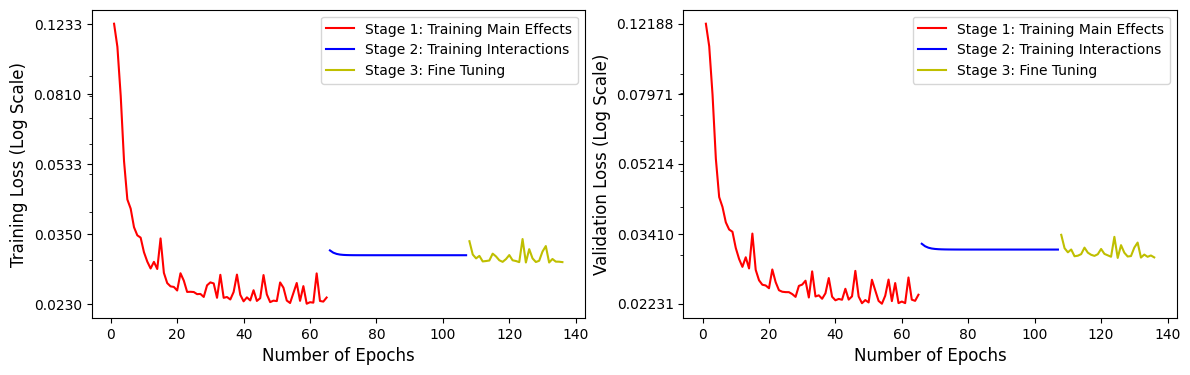

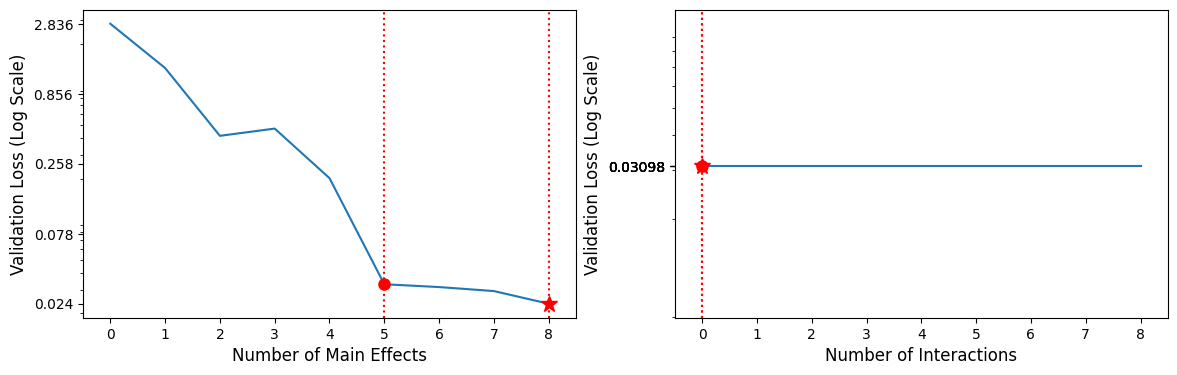

In [61]:
data_dict_logs=gami_mdl.summary_logs(save_dict=False)
plot_trajectory(data_dict_logs)
plot_regularization(data_dict_logs)

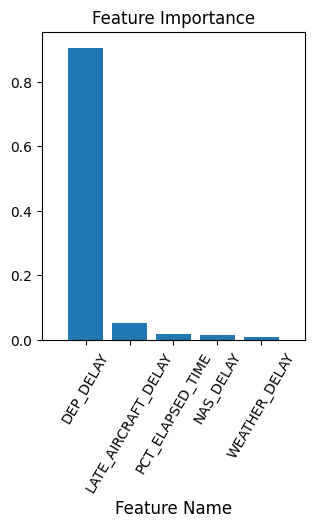

In [62]:
#Global Interpretation
data_dict_global=gami_mdl.global_explain(save_dict=True)
feature_importance_visualize(data_dict_global)
plt.show()

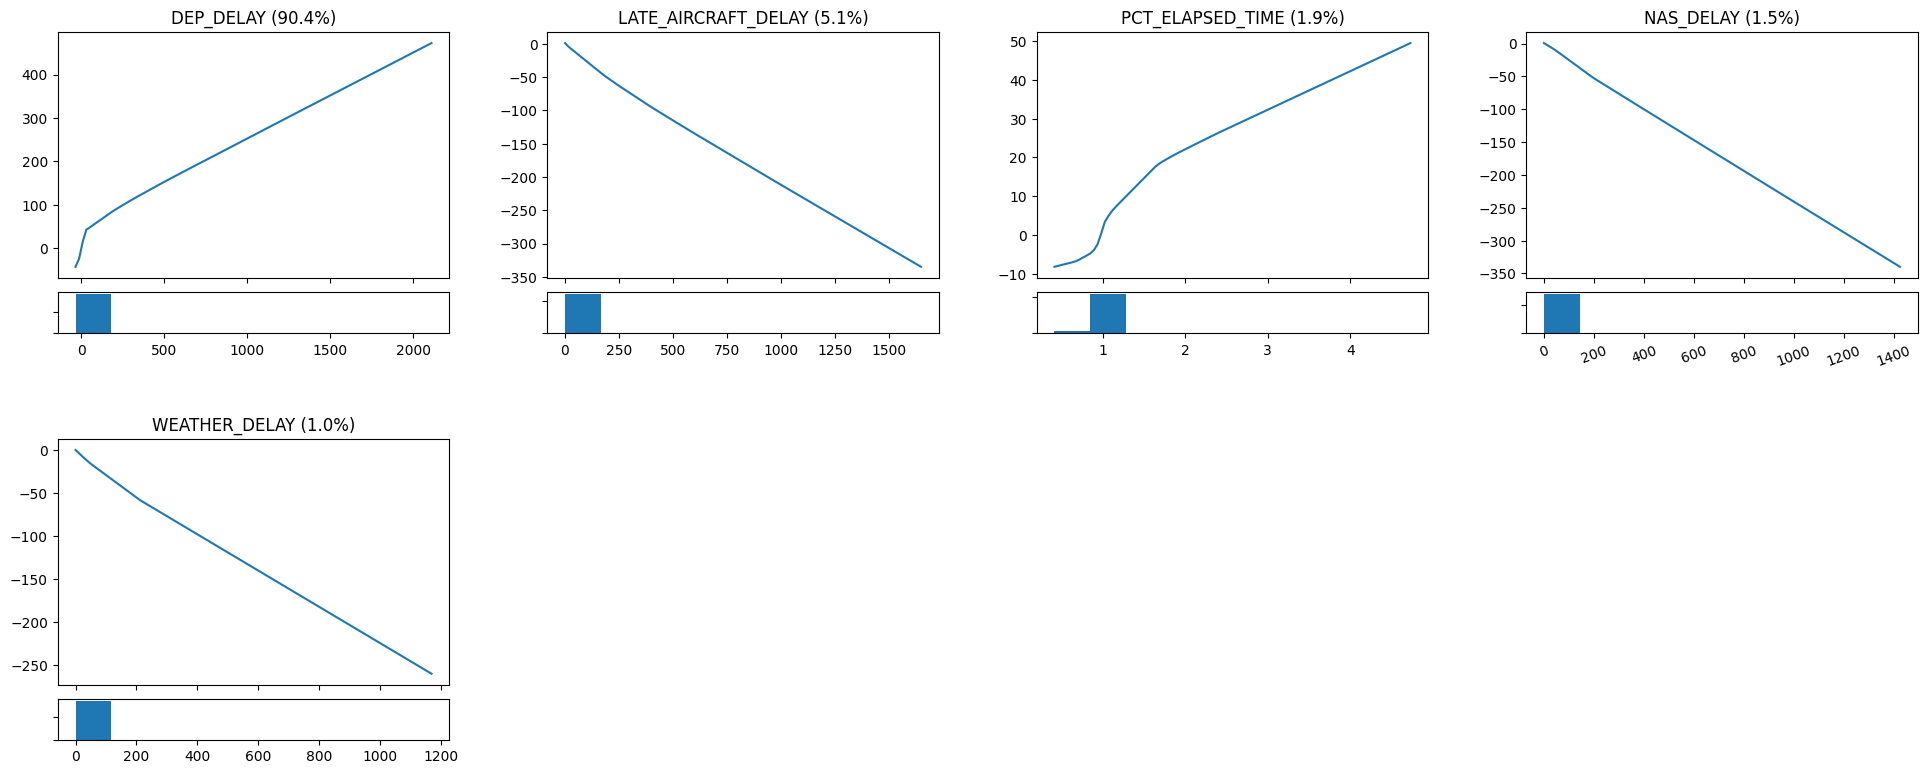

In [63]:
global_visualize_density(data_dict_global, name="flight_delay_global", main_effect_num=8, interaction_num=1,
                         cols_per_row = 4, save_png=True, save_eps=True)

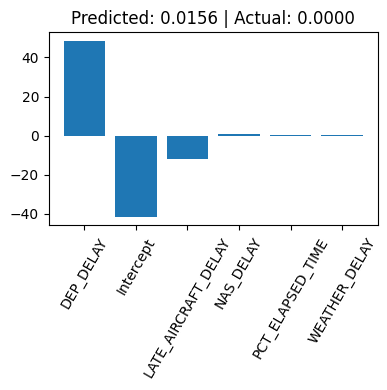

In [64]:
#Local Interpreation
data_dict_local=gami_mdl.local_explain(X_test_abbrev2[[73]], y_test_class2[[73]], save_dict=False)
local_visualize(data_dict_local[0])
plt.tight_layout()
plt.show()

In [66]:
#Performance
y_test_prob=gami_mdl.predict(X_test_abbrev2)
y_test_pred=np.where(y_test_prob > 0.5, 1, 0)
print('accuracy: %.3g, reclass : %.3g, roc auc: %.3g, f1: %.3g, mcc :%.3g' %\
      (metrics.accuracy_score(y_test_class2, y_test_pred),
       metrics.recall_score(y_test_class2, y_test_pred),
       metrics.roc_auc_score(y_test_class2, y_test_pred),
       metrics.f1_score(y_test_class2, y_test_pred),
       metrics.matthews_corrcoef(y_test_class2, y_test_pred)))

accuracy: 0.99, reclass : 0.894, roc auc: 0.945, f1: 0.916, mcc :0.911
